# Differential genefusion SVs between PCAWG and 1KG

Ideas:

- Use 1kg genefusion evidence to filter PCAWG results.
- Calculate global distribution of fusions
    - Any genefusion greater than median will be discarded
- Calculate local distribution of fusions (per gene)
    - Gene-wise filtering: for each gene, compute the top qth percentile of fusions in the genefusion count distribution. There is sufficient evidence these genefusions are common in the healthy population
    - Or, use median of medians instead of global median
- Population-wise filtering: compute the 95th percentile of normalized count for each gene's genefusion count distribution. Take a distribution of these 95th percentiles. Use the median or 95th percentile imposed on the 95th percentile distribution as filter criteria

## Imports

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import multiprocessing as mp
from functools import partial
import itertools
import math
os.chdir('/data/jake/genefusion/scripts/python')
#cpus = mp.cpu_count()  // 2
cpus = 64
print(cpus)

64


## Data

genes and locations

In [141]:
gene_file='/data/jake/genefusion/data/gene_file.txt'
df_genes = pd.read_csv(gene_file, sep='\t', header = None)
df_genes.columns = ['chrm', 'start', 'end', 'gene', 'strand']
def gene_location(df_genes, gene):
    gene_row = df_genes[df_genes['gene'] == gene]
    chrm = gene_row['chrm'].values[0]
    start = gene_row['start'].values[0]
    end = gene_row['end'].values[0]
    
    return chrm, start, end
print(gene_location(df_genes, 'OR4F5'))
df_genes.head()
GENES=df_genes['gene'].values.tolist()
GENES = np.unique(GENES).tolist()
len(GENES)

('1', np.int64(69091), np.int64(70008))


26909

In [143]:
# pd.Series(GENES).value_counts().sort_values(ascending=False).head()

- Duplicate gene names exist: 
    - Example: NPIPA7,TM9SF1, etc.
    - from '/data/jake/genefusion/data/gene_file.txt' there is a pattern. The duplicate genes are located on the same chromosome. The difference is that the start and end points vary slightly.
    - Adress this by recording the gene chrm, start, end region
    

In [135]:
# def add_suffix_to_duplicates(strings):
#     count = {}
#     result = []
#     for s in strings:
#         if s in count:
#             count[s] += 1
#             result.append(f"{s}_{count[s]}")
#         else:
#             count[s] = 0
#             result.append(s)
#     return result
# GENES = add_suffix_to_duplicates(GENES)
# [x for x in GENES if '_' in x][:2]

In [144]:
df_genes['gene_loc'] = df_genes.apply(
    lambda row: f'{row["gene"]}_{row["chrm"]}_{row["start"]}_{row["end"]}', 
    axis=1
)
print(df_genes['gene'].unique().shape,df_genes['gene_loc'].unique().shape)
df_genes.head()

(26909,) (26998,)


,chrm,start,end,gene,strand,gene_loc
0,1,69091,70008,OR4F5,pos,OR4F5_1_69091_70008
1,1,134901,139379,AL627309.1,neg,AL627309.1_1_134901_139379
2,1,139790,140339,RP11neg34P13.14,neg,RP11neg34P13.14_1_139790_140339
3,1,367640,368634,OR4F29,pos,OR4F29_1_367640_368634
4,1,621059,622053,OR4F16,neg,OR4F16_1_621059_622053


In [93]:
# GENES_W_LOC = df_genes['gene_loc'].values.tolist()
# GENES_W_LOC.sort()
# GENES_W_LOC[:5]

['7SK_8_144624280_144624570',
 'A1BG_19_58856544_58864865',
 'A1BGnegAS1_19_58859117_58866549',
 'A1CF_10_52559169_52645435',
 'A2ML1_12_8975068_9039597']

## 1kg

In [6]:
#dir_pcawg = '/data/jake/genefusion/data/2024_10_31-fusions'
dir_1kg = '/data/jake/genefusion/data/2024_11_01-fusions-1kg'
dir_1kg_fusions = os.path.join(dir_1kg, 'fusions')

In [7]:
os.listdir(dir_1kg_fusions)[0:5]

['1.neg.ZNF669.247263264.247267674.fusions',
 '17.neg.CCL3.34415602.34417515.fusions',
 '20.pos.VAPB.56964178.57026157.fusions',
 '10.pos.RP11neg162G10.5.38146668.38148038.fusions',
 '11.neg.RP5neg901A4.1.67792277.67797928.fusions']

In [87]:
fusionfiles = glob.glob(os.path.join(dir_1kg_fusions, '*.fusions'))
print(len(fusionfiles))
# filter out empty files
#fusionfiles = [f for f in fusionfiles if os.stat(f).st_size > 0]
print(len(fusionfiles))

26998
26998


## ERG (chrm 21 neg)

In [97]:
regex = re.compile('21\\.neg\\.ERG')
regex
for file in os.listdir(dir_1kg_fusions):
    if regex.search(file):
        ergfile = file
try: 
    ergfile
except NameError:
    print('No ERG file found')

In [98]:
df_erg = pd.read_csv(os.path.join(dir_1kg_fusions, ergfile), sep='\t',header=None)
df_erg.columns = ['chrm', 'start', 'end', 'gene', 'strand']
df_erg.head()

,chrm,start,end,gene,strand
0,21,39756323,39756358,ERG,neg
1,21,39756691,39756781,ERG,neg
2,21,39760265,39760366,ERG,neg
3,21,39755190,39755292,ERG,neg
4,21,39753426,39753527,ERG,neg


### Mode

In [10]:
# including self
print(df_erg['gene'].mode())
print(df_erg['gene'].value_counts().max())
# self value
# non-self
print(df_erg['gene'][df_erg['gene'] != 'ERG'].mode())
# mode value
df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().max()

0    ERG
Name: gene, dtype: object
9813
0    DMD
Name: gene, dtype: object


np.int64(111)

### Count ranks and distributions

In [294]:
counts = df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().sort_values(ascending=False)
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
print(qs)
counts.head()

[ 1.   3.   7.  21.5]


gene
DMD         111
TM4SF2       99
LARGE        78
IL1RAPL1     73
DSCAM        61
Name: count, dtype: int64

In [ ]:
count

[0.         0.47712125 0.84509804 1.35111   ]


[]

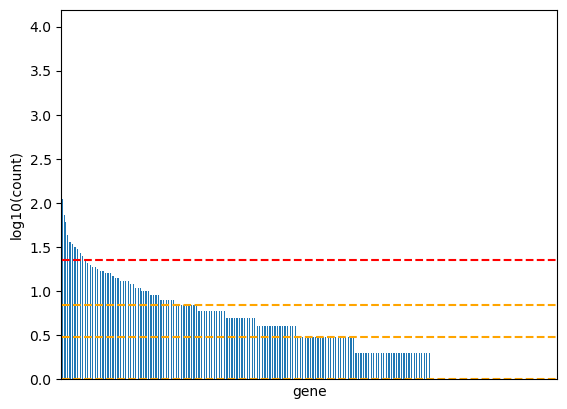

In [293]:
counts = df_erg['gene'].value_counts().apply(lambda x: np.log10(x))
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
print(qs)
ax = counts.plot(kind='bar', )
ax.hlines(y=qs[0:3], xmin=0, xmax=counts.shape[0], color='orange', linestyle='--')
ax.hlines(y=qs[3], xmin=0, xmax=counts.shape[0], color='red', linestyle='--')

ax.set_ylabel('log10(count)')
ax.set_xticks([])  
ax.set_xticklabels([]) 

#### >= 95th% counts

In [154]:
counts = df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().sort_values(ascending=False)
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
counts_95 = counts[counts > qs[3]]
counts_95

gene
DMD          111
TM4SF2        99
LARGE         78
IL1RAPL1      73
DSCAM         61
MTnegND5      53
TTC28         47
SYN3          44
MTnegND4      44
MTnegRNR2     42
DHRSX         36
MTnegCO1      36
NLGN4X        36
FRMPD4        35
MTnegCYB      34
ARHGAP6       34
RBFOX2        33
MTnegCO3      32
PCDH11Y       32
MTnegRNR1     31
FAM19A5       30
CECR2         30
MKL1          30
TBC1D22A      30
TNRC6B        29
EFCAB6        27
NHS           25
MTnegND6      25
PACSIN2       25
REPS2         25
MTnegATP6     24
MTnegND1      24
MTnegND2      23
KIAA1671      23
MID1          22
Name: count, dtype: int64

This is the set we'd like to subtract from PCAWG population

### Mobility tendency

#### 95th percentile

In [63]:
counts_95.index.tolist()[0:5]

['DMD', 'TM4SF2', 'LARGE', 'IL1RAPL1', 'DSCAM']

In [81]:
locations_95 = {}
for gene in counts_95.index:
    locations_95[gene] = gene_location(df_genes, gene)
locations_95 = pd.DataFrame.from_dict(locations_95, orient='index', columns=['chrm', 'start', 'end'])
locations_95.chrm.value_counts()

chrm
22    12
MT    11
X     10
21     1
Y      1
Name: count, dtype: int64

## Population stats

Normalize counts to [0,1] frequencies for comparison across populations

In [151]:
def get_95(fusionfile, normalize=False):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None)
    df.columns = ['chrm', 'start', 'end', 'gene', 'strand']
    counts = df['gene'][df['gene'] != gene].value_counts(normalize=normalize)\
        .sort_values(ascending=False)
    q = float(np.quantile(counts, 0.95))
    return q
print(get_95(os.path.join(dir_1kg_fusions, '21.neg.ERG.39751949.40033704.fusions')))
print(get_95(os.path.join(dir_1kg_fusions, '21.neg.ERG.39751949.40033704.fusions'), normalize=True))

21.5
0.004821708903341556


In [125]:
%%capture
with mp.Pool(processes=cpus) as pool:
    dist_95 = pool.map(get_95, fusionfiles)
dist_95[0:5]

In [129]:
filt_95 = [x for x in dist_95 if x is not None]
filt_95[0:5]

[2.0, 4.3999999999999915, 8.5, 1.0, 2.0]

In [130]:
pd.Series(filt_95).describe()

count    25924.000000
mean         7.174452
std         22.957931
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max       2563.600000
dtype: float64

In [131]:
pd.Series(filt_95).quantile(0.95)

np.float64(22.0)

- Median of 95th percentile distribution is 4

- 95th of 95th percentile distribution is 22

### Normalized counts

In [134]:
%%capture
normalize = True
with mp.Pool(processes=cpus) as pool:
    get_95_norm = partial(get_95, normalize=normalize)
    dist_95_norm = pool.map(get_95_norm,fusionfiles)
dist_95_norm[0:5]

In [135]:
filt_95_norm = [x for x in dist_95_norm if x is not None]
filt_95_norm[0:5]

[0.0008090614886731392,
 0.030344827586206838,
 0.005286069651741294,
 0.004424778761061947,
 0.0014124293785310734]

In [137]:
pd.Series(filt_95_norm).describe()

count    25924.000000
mean         0.008536
std          0.044347
min          0.000067
25%          0.000509
50%          0.001144
75%          0.003602
max          1.000000
dtype: float64

In [138]:
pd.Series(filt_95_norm).quantile(0.95)

np.float64(0.019417475728155338)

Use the preceeding results as a gene-wise filter for PCAWG.

Example

If a genefusion has a relative frequency of >20% (95th%tile) within its count distribution in the 1000 genomes population, then ignore it in PCAWG population.

#### Gene-wise filtering

In [169]:
def healthy_fusions(fusionfile, q = 0.95, normalize=True):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None)
    df.columns = ['chrm', 'start', 'end', 'gene', 'strand']
    counts = df['gene'][df['gene'] != gene].value_counts(normalize=normalize).sort_values(ascending=False)
    qp = float(np.quantile(counts, q))
    h_fusions = counts[counts > qp].index.tolist()
    h_fusions = [f'{gene}+{x}' for x in h_fusions]
    return h_fusions
healthy_fusions('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')   

['ERG+DMD',
 'ERG+TM4SF2',
 'ERG+LARGE',
 'ERG+IL1RAPL1',
 'ERG+DSCAM',
 'ERG+MTnegND5',
 'ERG+TTC28',
 'ERG+SYN3',
 'ERG+MTnegND4',
 'ERG+MTnegRNR2',
 'ERG+DHRSX',
 'ERG+MTnegCO1',
 'ERG+NLGN4X',
 'ERG+FRMPD4',
 'ERG+MTnegCYB',
 'ERG+ARHGAP6',
 'ERG+RBFOX2',
 'ERG+MTnegCO3',
 'ERG+PCDH11Y',
 'ERG+MTnegRNR1',
 'ERG+FAM19A5',
 'ERG+CECR2',
 'ERG+MKL1',
 'ERG+TBC1D22A',
 'ERG+TNRC6B',
 'ERG+EFCAB6',
 'ERG+NHS',
 'ERG+MTnegND6',
 'ERG+PACSIN2',
 'ERG+REPS2',
 'ERG+MTnegATP6',
 'ERG+MTnegND1',
 'ERG+MTnegND2',
 'ERG+KIAA1671',
 'ERG+MID1']

In [170]:
%%capture
with mp.Pool(processes=cpus) as pool:
    h_fusions = pool.map(healthy_fusions, fusionfiles)

In [171]:
len(list(itertools.chain.from_iterable(h_fusions)))

3786645

In [174]:
%%capture
with mp.Pool(processes=cpus) as pool:
    partial_healthy_fusions = partial(healthy_fusions, q=0.5, normalize=True)
    h_fusions_med = pool.map(partial_healthy_fusions, fusionfiles)

In [175]:
len(list(itertools.chain.from_iterable(h_fusions_med)))

34375533

Median filtering

- Compute genefusion median per gene
- Take median of medians
- Filter any genefusion above median count

In [191]:
def gene_wise_median(fusionfile):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = ['gene']
    median = int(df['gene'].value_counts().median())
    return median
gene_wise_median('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')   

3

In [195]:
with mp.Pool(processes=cpus) as pool:
    medians = pool.map(gene_wise_median, fusionfiles)

In [198]:
# median of medians
np.median(medians)

np.float64(1.0)

Text(0.5, 1.0, 'Distribution of gene-wise median fusion counts')

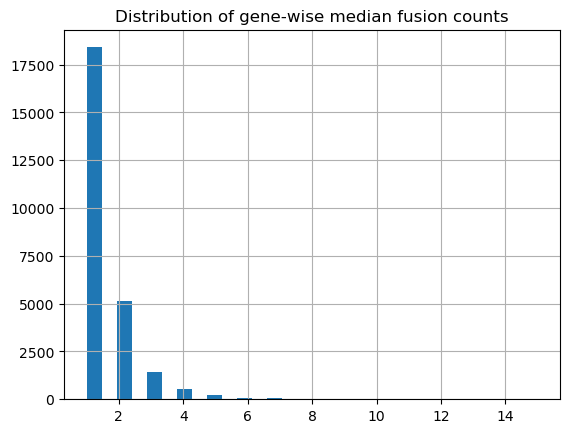

In [205]:
pd.Series(medians).hist(bins=30)
plt.title('Distribution of gene-wise median fusion counts')

In [208]:
pd.Series(medians).value_counts()

1     18404
2      5134
3      1435
4       536
5       199
6        86
7        60
8        32
9        12
10        9
11        6
12        5
13        4
15        1
14        1
Name: count, dtype: int64

Applying >1 filter to all genefusion pairs

In [207]:
def healthy_fusions(fusionfile, threshold=1):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = ['gene']
    counts = df['gene'][df['gene'] != gene].value_counts()
    h_fusions = counts[counts > threshold].index.tolist()
    h_fusions = [f'{gene}+{x}' for x in h_fusions]
    return h_fusions
healthy_fusions('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')[0:5]

['ERG+DMD', 'ERG+TM4SF2', 'ERG+LARGE', 'ERG+IL1RAPL1', 'ERG+DSCAM']

In [211]:
outfile_hf= '/data/jake/genefusion/data/healthy_fusions.txt'
def helper(fusionsfile, outfile= outfile_hf):
    with open(outfile, 'a') as f:
        hf = healthy_fusions(fusionsfile, threshold=1)
        for line in hf:
            f.write(line + '\n')
with mp.Pool(processes=cpus) as pool:
    pool.map(helper, fusionfiles)
    

In [215]:
with open(outfile_hf, 'rb') as f:
    n_hf = sum(1 for _ in f)
print(n_hf)
print(n_hf * 10 ** -6, 'M')

48336949
48.336949 M


In [222]:
comb = math.comb(27000,2) * 10 ** -6
comb

364.4865

## Summary

- 3.8M genefusions filtered out by gene-wise 95th percentile
- 34M genefusions filtered out by gene-wise median
- 48M genefusions filtered by median of means (gene fusion count >1)

## Fusion count matrix

- notes:
  - some genes had no fusions
  - some genes have 'gene.2' naming; '.' is the same delimiter I used for file naming.
    - Can still parse from filenames by using forward and reverse splits
      - Example: filename.split('.')[2] -> strand; filename.split('.')[-3] -> start

In [222]:
def filestring2data(string):
    # assumes .giggle extension
    chrm = string.split('.')[0]
    strand = string.split('.')[1]
    gene = string.split('.')[2]
    start = string.split('.')[-3]
    end = string.split('.')[-2]
    # handle rare case where gene name has a period
    if len(string.split('.')) >= 7:
        gene = '.'.join(string.split('.')[2:-3])
    return [chrm, strand, gene, start, end]

In [224]:
# filestring2data('21.neg.ERG.39751949.40033704.giggle')
filestring2data('1.pos.RP3neg426I6.5.28100369.28100552.fusions')

['1', 'pos', 'RP3neg426I6.5', '28100369', '28100552']

In [226]:
print(len(fusionfiles),len(GENES))

26998 26909


In [230]:
def count_gene_var_pairs(fusionfile, GENES=GENES):
    base = os.path.basename(fusionfile)
    gene = str(base.split('.')[2])
    chrm,strand,gene,start,end = filestring2data(base) 
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = [gene]
    counts = df[gene].value_counts()
    counts.name = gene
    return counts
znf = count_gene_var_pairs(fusionfiles[0]).head()
    

In [231]:
fusionfiles[0]

'/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/1.neg.ZNF669.247263264.247267674.fusions'

In [232]:
znf.name

'ZNF669'

In [233]:
fusionfiles_not_empty = [f for f in fusionfiles if os.stat(f).st_size > 0]
fusionfiles_empty = [f for f in fusionfiles if os.stat(f).st_size == 0]
fusionfiles_empty[:5]

['/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/X.neg.SRPX.38008589.38080696.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/X.neg.TAF7L.100523241.100548059.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/Y.neg.FAM197Y8.9185120.9193010.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/X.pos.NXF2.101470280.101581634.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/X.neg.NAA10.153194695.153200676.fusions']

In [234]:
empty_genes = [os.path.basename(f).split('.')[2] for f in fusionfiles_empty]
print(len(empty_genes))
empty_genes[:5]

1074


['SRPX', 'TAF7L', 'FAM197Y8', 'NXF2', 'NAA10']

In [235]:
with mp.Pool(processes=cpus) as pool:
    gene_var_pairs = pool.map(count_gene_var_pairs, fusionfiles_not_empty)

In [236]:
print(type(gene_var_pairs[0]))
print(gene_var_pairs[0].shape)
gene_var_pairs[0].head()

<class 'pandas.core.series.Series'>
(1967,)


ZNF669
ARID2       90
ZNF669      67
RPH3AL       9
ARHGAP15     6
ROBO2        6
Name: ZNF669, dtype: int64

In [268]:
names = [x.name for x in gene_var_pairs]
names = pd.Series(names).value_counts()
names.head()

NPIPA7    3
ZNF763    2
UGT2A1    2
MUC3A     2
LCN6      2
Name: count, dtype: int64

In [239]:
for n in names.items():
    print(n)
    break

('NPIPA7', 3)


In [253]:
# this takes far too long (~10 hours; try using shared array and parallelizing entry filling)
n = len(GENES)
A = np.zeros((n,n),dtype=np.int64)
A = pd.DataFrame(A, index=GENES, columns=GENES)
# i = 0
for source in gene_var_pairs:
    for target, count in source.items():
        A.loc[source.name, target] += count
    # i += 1
    # if i >=10:
    #     break
# mask = A.index.str.contains('RP3neg508I15')
# A[mask]

In [254]:
A.to_csv('/data/jake/genefusion/data/1kg-gene_var_pairs.csv',sep='\t')

In [255]:
A.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [269]:
# likely unused
# sort fusionfiles by gene name
# df_fusionfiles = pd.DataFrame(fusionfiles, columns=['file'])
# df_fusionfiles['gene_loc'] = df_fusionfiles['file'].apply(lambda x: filestring2data(os.path.basename(x)))
# # reorder
# df_fusionfiles['gene_loc'] = df_fusionfiles['gene_loc'].apply(lambda x: f'{x[2]}_{x[0]}_{x[3]}_{x[4]}')
# df_fusionfiles_sort = df_fusionfiles.sort_values('gene_loc').reset_index(drop=True)
# df_fusionfiles_sort

In [270]:
# for i, file in enumerate(df_fusionfiles_sort['file'].values):
#     print(file)
#     base_i = os.path.basename(file)
#     gene_i = base_i.split('.')[2]
#     fusions = pd.read_csv(file, sep='\t', header=None, usecols=[3])
#     fusions.columns = ['gene']
#     fusions = fusions['gene'].value_counts().sort_values(ascending=False)
#     for gene in GENES:
#         if not gene in fusions.index.tolist():
#             # fill absent genes with 0
#             fusions.loc[gene] = 0
#     break
# fusions

In [253]:
# very slow; do parallel gene-wise, then (h/v)stack concatenate
# use npz format to store
n = len(genes)
A = np.zeros((n,n),dtype=np.int32)
for i, file in enumerate(df_fusionfiles_sort['file'].values):
    base_i = os.path.basename(file)
    gene_i = base_i.split('.')[2]
    fusions = pd.read_csv(file, sep='\t', header=None, usecols=[3])
    fusions.columns = ['gene']
    fusions = fusions['gene'].value_counts()
    for gene_j, count in fusions.items():
        A[i, gene_j] = count
A_f = fusion_matrix(fusionfiles, genes)
A_f.head()

/tmp/ipykernel_1957274/2124268439.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  A.loc[gene_i, gene_j] = count
/tmp/ipykernel_1957274/2124268439.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  A.loc[gene_i, gene_j] = count
/tmp/ipykernel_1957274/2124268439.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

KeyboardInterrupt: 

In [ ]:
A_f.to_csv('/data/jake/genefusion/data/1kg_fusion_matrix.csv',sep='\t',compression='gzip')

In [275]:

npz_path = '/data/jake/genefusion/data/1kg-gene_var_pairs.npz'

In [271]:
npz_path = '/data/jake/genefusion/data/1kg-gene_var_pairs.npz'
np.savez_compressed(npz_path, data = C.to_numpy(), columns=C.columns.to_numpy(), index=C.index.to_numpy())


npz format takes only 10 seconds to load instead of 2 min for gzipped csv

In [266]:
# loaded = np.load(npz_path, allow_pickle=True)

# # Reconstruct DataFrame
# df_restored = pd.DataFrame(
#     loaded["data"],
#     columns=loaded["columns"],
#     index=loaded["index"]
# )

# df_restored.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZZ3,0,0,0,1,2,6,4,0,0,0,...,2,0,0,0,8,2108,0,0,0,17
hsanegmirneg1199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,25,0,0,0
hsanegmirneg150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,13,0,0
hsanegmirneg335,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30,0


## Gene fusion burden

- Source is row index
- Target is col index

Housekeeping genes

    GAPDH (Glyceraldehyde 3-phosphate dehydrogenase)
    HPRT1 (Hypoxanthine phosphoribosyltransferase 1)
    SDHA (Succinate dehydrogenase complex flavoprotein subunit A)
    B2M (Beta-2-microglobulin)
    UBC (Ubiquitin C)
    YWHAZ (Tyrosine 3-monooxygenase/tryptophan 5-monooxygenase activation protein zeta)
    ATF1, ATF2, ATF4, ATF6, ATF7 (Activating transcription factors)
    BTF3 (Basic transcription factor 3)
    E2F4 (E2F transcription factor 4)
    ERH (Enhancer of rudimentary homolog)
    HMGB1 (High mobility group box 1)
    ILF2 (Interleukin enhancer binding factor 2)


In [409]:
GENES_HK = {'GAPDH', 'HPRT1', 'SDHA', 'B2M', 'UBC', 'YWHAZ', 'ATF1', 'ATF2', 'ATF4', 'ATF6', 'ATF7', 'BTF3', 'E2F4', 'ERH', 'HMGB1', 'ILF2'}
GENES_HK2 = {
    "ACTB",
    "TUBB",
    "RPL13A",
    "PPIA",
    "TBP",
}
GENES_PC = {'TP53', 'RB1', 'PTEN', 'FOXA1', 'CDK12', 'AR', 'SPOP', 'LSAMP', 'PTPRD'}

In [276]:
loaded = np.load(npz_path, allow_pickle=True)
df_1kg_gp_var = pd.DataFrame(
    loaded["data"],
    columns=loaded["columns"],
    index=loaded["index"]
)
df_1kg_gp_var.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


### Across genes

For a source gene, count the number of distinct target genes with SV evidence. Yes -> 1, no -> 0

In [300]:
# >20 cpus may use too much mem
cpus = 20
def count2bool(count):
    return int(count > 0)
def process_chunk(df_chunk):
    return df_chunk.map(count2bool)
chunks = np.array_split(df_1kg_gp_var, cpus)
with mp.Pool(cpus) as pool:
    results = pool.map(process_chunk, chunks)
df_1kg_gp_var_distinct = pd.concat(results)

/data/jake/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [301]:
df_1kg_gp_var_distinct.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
A2M,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


Burden = row_sum + col_sum - 2
- -2 for self counts in both row and col

In [314]:
# cannot parallelize with df as argument, too much memory
# instead pass in only the row and col as necessary
def burden_distinct(gene,row,col):
    # -2 for self counts in both row and col
    return gene, row.sum() + col.sum() - 2
burden_distinct('A1CF', df_1kg_gp_var_distinct.loc['A1CF',:], df_1kg_gp_var_distinct.loc[:,'A1CF'])
    

('A1CF', np.int64(11282))

In [315]:
df_1kg_gp_var_distinct.loc['A1CF',:].sum() +\
df_1kg_gp_var_distinct.loc[:,'A1CF'].sum() - 2

np.int64(11282)

In [316]:
queries = [(gene, df_1kg_gp_var_distinct.loc[gene,:], df_1kg_gp_var_distinct.loc[:, gene]) for gene in GENES]
queries[1]

('A1BG',
 7SK                 0
 A1BG                1
 A1BGnegAS1          1
 A1CF                0
 A2M                 0
                    ..
 ZZZ3                0
 hsanegmirneg1199    0
 hsanegmirneg150     0
 hsanegmirneg335     0
 hsanegmirneg490     0
 Name: A1BG, Length: 26909, dtype: int64,
 7SK                 0
 A1BG                1
 A1BGnegAS1          1
 A1CF                1
 A2M                 0
                    ..
 ZZZ3                0
 hsanegmirneg1199    0
 hsanegmirneg150     0
 hsanegmirneg335     0
 hsanegmirneg490     0
 Name: A1BG, Length: 26909, dtype: int64)

In [317]:
cpus = 30

with mp.Pool(cpus) as pool:
    #burden_distinct_partial = partial(burden_distinct, df_1kg_gp_var)
    burden_distincts = pool.starmap(burden_distinct, queries)
burden_distincts[0:5]

[('7SK', np.int64(189)),
 ('A1BG', np.int64(3601)),
 ('A1BGnegAS1', np.int64(2941)),
 ('A1CF', np.int64(11282)),
 ('A2M', np.int64(8614))]

In [356]:
%pip install datashader

  Using cached datashader-0.16.3-py2.py3-none-any.whl.metadata (12 kB)
  Using cached colorcet-3.1.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached dask-2024.11.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached multipledispatch-1.0.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached numba-0.60.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached param-2.1.1-py3-none-any.whl.metadata (7.2 kB)
  Using cached pyct-0.5.0-py2.py3-none-any.whl.metadata (7.4 kB)
  Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached xarray-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached cloudpickle-3.1.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached partd-1.4.2-py3-none-any.whl.metadata (4.6 kB)
  Us

In [360]:
%pip install datashader

Note: you may need to restart the kernel to use updated packages.


<Axes: >

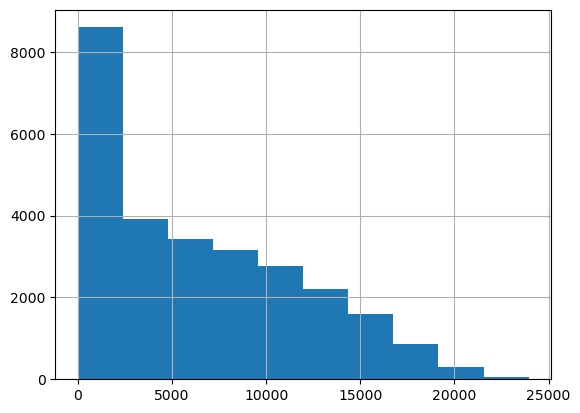

In [366]:
burden_distincts_ser = pd.Series(burden_distincts)
burden_distincts_ser.hist()

In [385]:
%pip install seaborn
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_158195/2252010242.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




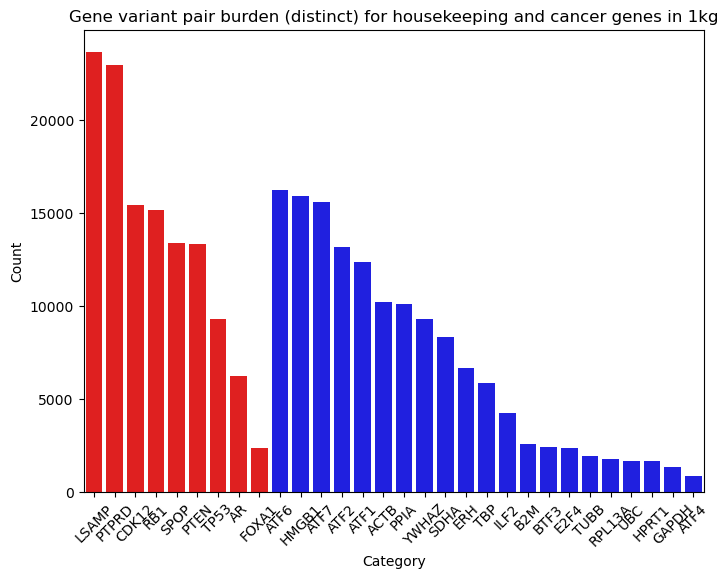

In [423]:
mask = [i for i in burden_distincts_ser.index.tolist() if i in GENES_HK.union(GENES_PC, GENES_HK2)]
df_burden_sub = pd.DataFrame(burden_distincts_ser[mask])
df_burden_sub['color'] = df_burden_sub.index.map(lambda x: 'red' if x in GENES_PC else 'blue')
df_burden_sub.columns = ['count', 'color']
df_burden_sub.sort_values(['color', 'count'], ascending=False, inplace=True)
df_burden_sub['length'] = df_burden_sub.index.map(lambda x: gene_location(df_genes, x)[2] - gene_location(df_genes, x)[1])
df = df_burden_sub
df.head()
plt.figure(figsize=(8, 6))
sns.barplot(x=df.index, y='count', data=df, palette=df['color'].tolist())

# # Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Gene variant pair burden (distinct) for housekeeping and cancer genes in 1kg')
plt.xticks(rotation=45)


# Show the plot
plt.show()

/tmp/ipykernel_158195/3347778395.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




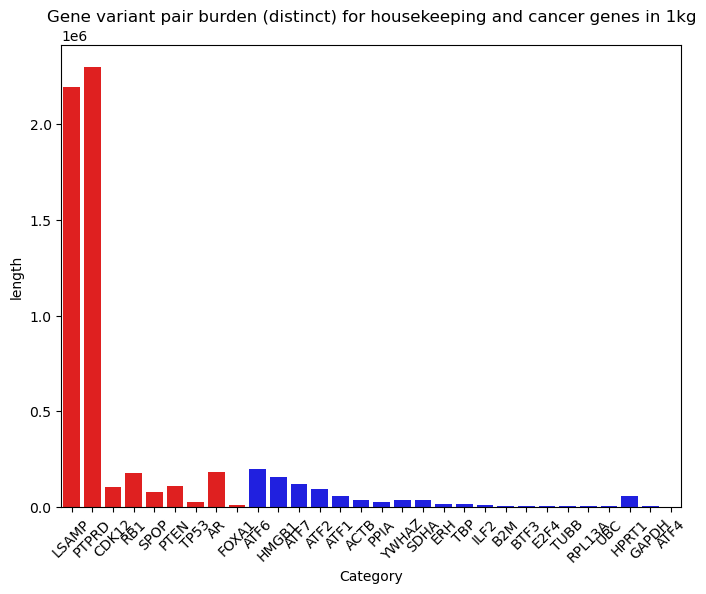

In [424]:
#df = df.sort_values(['color', 'length'], ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=df.index, y='length', data=df, palette=df['color'].tolist())

# # Add labels and title
plt.xlabel('Category')
plt.ylabel('length')
plt.title('Gene variant pair burden (distinct) for housekeeping and cancer genes in 1kg')
plt.xticks(rotation=45)


# Show the plot
plt.show()

### Burden and length correlation


In [427]:
print(117716095 - 115521235, 37721160 - 37617764)

2194860 103396


In [441]:
from sklearn.preprocessing import MinMaxScaler
df = burden_distincts_ser.to_frame()
df.columns = ['count']
df['length'] = df.index.map(lambda x: gene_location(df_genes, x)[2] - gene_location(df_genes, x)[1])
df.head()


,count,length
7SK,189,290
A1BG,3601,8321
A1BGnegAS1,2941,7432
A1CF,11282,86266
A2M,8614,48565


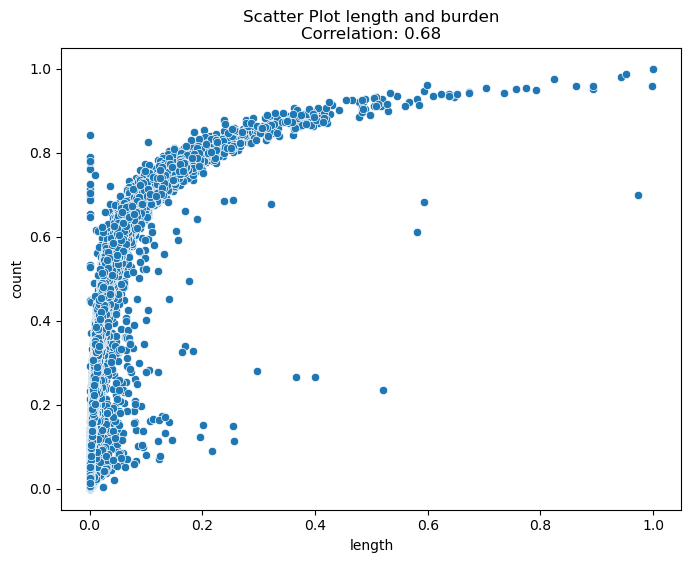

In [442]:
df_scaled = df.copy()
df_scaled['count'] = scaler.fit_transform(df[['count']])
df_scaled['length'] = scaler.fit_transform(df[['length']])
cor = df_scaled['length'].corr(df_scaled['count'])
correlation = df_scaled['length'].corr(df_scaled['count'])

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='length', y='count', data=df_scaled)

# Display the correlation coefficient on the plot
plt.title(f'Scatter Plot length and burden\nCorrelation: {correlation:.2f}')
plt.xlabel('length')
plt.ylabel('count')

# Show the plot
plt.show()

In [439]:
58864865 - 58856544

8321